# Pre-Coding EDA

This notebook explores the five environmental datasets used in our Streamlit application. The goal is to understand the structure, quality, and quirks of each dataset before creating the scripts and the application.

We use the following 5 datasets (all sourced from Our World in Data):

| # | Dataset | Description |
|---|---------|-------------|
| 1 | Annual change in forest area | Net change in forest cover as a % of total forest area |
| 2 | Annual deforestation | Hectares of forest lost per year |
| 3 | Share of land that is protected | % of a country's land area under environmental protection |
| 4 | Share of land that is degraded | % of land suffering from degradation |
| 5 | Share of marine protected areas | % of a country's marine territory under protection |

A sixth dataset — the **Natural Earth Admin 0 Countries** shapefile — provides the country geometries for map visualisation and is also examined here for merge compatibility.

**What we explore:**

1. **Dataset structure** — shape, columns, dtypes, first rows
2. **Missing values** — which columns and how many
3. **Duplicates** — full row duplicates and duplicate (Entity, Year) pairs
4. **Entity analysis** — separating real countries from OWID aggregates (e.g. "World", "Europe")
5. **Year ranges** — time coverage per dataset
6. **Value distributions & outliers** — histograms, box plots, IQR-based detection
7. **Merge key compatibility** — how OWID's `Code` column aligns with Natural Earth's ISO columns

# 0. Setup & Data Download

In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import urllib.request
import os

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

# creating downloads directory

DOWNLOAD_DIR = Path("../downloads")
DOWNLOAD_DIR.mkdir(exist_ok=True)

In [3]:
# loading all datasets locally from the downloads folder (this step will later be replaced by downloading the datasets from the web with the download_files function)

DATASET_FILES = {
    "forest_change": "forest_change.csv",
    "deforestation": "deforestation.csv",
    "land_protected": "land_protected.csv",
    "land_degraded": "land_degraded.csv",
    "marine_protected": "marine_protected.csv",
}

dfs = {}
for name, filename in DATASET_FILES.items():
    filepath = DOWNLOAD_DIR / filename
    dfs[name] = pd.read_csv(filepath)
    print(f"{name}: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")

forest_change: 488 rows, 4 columns
deforestation: 705 rows, 4 columns
land_protected: 2689 rows, 4 columns
land_degraded: 268 rows, 4 columns
marine_protected: 2205 rows, 4 columns


# 1. Dataset Overview

For each dataset, we check shape, columns, datatypes, first rows, and basic stats.

In [4]:
for name, df in dfs.items():
    print(f"\n{'='*60}")
    print(f"DATASET: {name}")
    print(f"{'='*60}")
    print(f"\nShape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nDtypes:\n{df.dtypes}")
    print(f"\nFirst 3 rows:")
    display(df.head(3))
    print(f"\nBasic statistics:")
    display(df.describe())


DATASET: forest_change

Shape: (488, 4)

Columns: ['entity', 'code', 'year', '_15_2_1__ag_lnd_frstchg']

Dtypes:
entity                         str
code                           str
year                         int64
_15_2_1__ag_lnd_frstchg    float64
dtype: object

First 3 rows:


,entity,code,year,_15_2_1__ag_lnd_frstchg
0,Afghanistan,AFG,2010,0.00
1,Afghanistan,AFG,2020,0.00
2,Africa (UN),NaN,2010,-0.49



Basic statistics:


,year,_15_2_1__ag_lnd_frstchg
count,488.000000,488.000000
mean,2015.000000,-0.043709
std,5.005131,0.815010
min,2010.000000,-3.710000
25%,2010.000000,-0.280000
50%,2015.000000,0.000000
75%,2020.000000,0.112500
max,2020.000000,6.210000



DATASET: deforestation

Shape: (705, 4)

Columns: ['entity', 'code', 'year', '_1d_deforestation']

Dtypes:
entity                 str
code                   str
year                 int64
_1d_deforestation    int64
dtype: object

First 3 rows:


,entity,code,year,_1d_deforestation
0,Africa,NaN,1990,3065370
1,Africa,NaN,2000,3590590
2,Africa,NaN,2010,4054850



Basic statistics:


,year,_1d_deforestation
count,705.000000,7.050000e+02
mean,2007.163121,3.242838e+05
std,10.598311,1.325805e+06
min,1990.000000,0.000000e+00
25%,2000.000000,2.000000e+01
50%,2010.000000,5.430000e+03
75%,2015.000000,8.164000e+04
max,2020.000000,1.581883e+07



DATASET: land_protected

Shape: (2689, 4)

Columns: ['entity', 'code', 'year', 'er_lnd_ptld_zs']

Dtypes:
entity                str
code                  str
year                int64
er_lnd_ptld_zs    float64
dtype: object

First 3 rows:


,entity,code,year,er_lnd_ptld_zs
0,Afghanistan,AFG,2013,0.4
1,Afghanistan,AFG,2014,0.4
2,Afghanistan,AFG,2015,0.4



Basic statistics:


,year,er_lnd_ptld_zs
count,2689.000000,2689.000000
mean,2018.528449,17.188275
std,3.448390,12.556158
min,2013.000000,0.000000
25%,2016.000000,7.500000
50%,2019.000000,15.503416
75%,2022.000000,23.300000
max,2024.000000,100.000000



DATASET: land_degraded

Shape: (268, 4)

Columns: ['entity', 'code', 'year', '_15_3_1__ag_lnd_dgrd']

Dtypes:
entity                      str
code                        str
year                      int64
_15_3_1__ag_lnd_dgrd    float64
dtype: object

First 3 rows:


,entity,code,year,_15_3_1__ag_lnd_dgrd
0,Algeria,DZA,2015,2.44
1,Algeria,DZA,2019,5.00
2,Antigua and Barbuda,ATG,2015,9.78



Basic statistics:


,year,_15_3_1__ag_lnd_dgrd
count,268.000000,268.000000
mean,2016.985075,13.527948
std,2.003686,11.199073
min,2015.000000,0.000000
25%,2015.000000,5.632500
50%,2015.000000,10.205000
75%,2019.000000,19.040000
max,2019.000000,71.930000



DATASET: marine_protected

Shape: (2205, 4)

Columns: ['entity', 'code', 'year', 'er_mrn_ptmr_zs']

Dtypes:
entity                str
code                  str
year                int64
er_mrn_ptmr_zs    float64
dtype: object

First 3 rows:


,entity,code,year,er_mrn_ptmr_zs
0,Albania,ALB,2013,1.4
1,Albania,ALB,2014,1.0
2,Albania,ALB,2015,1.0



Basic statistics:


,year,er_mrn_ptmr_zs
count,2205.000000,2205.000000
mean,2018.538322,7.857279
std,3.448349,16.353061
min,2013.000000,0.000000
25%,2016.000000,0.100000
50%,2019.000000,1.400000
75%,2022.000000,8.600000
max,2024.000000,100.000000


**Findings:**
1. All columns are lowercase (`entity`, `code`, `year`), using OWID's short name format 
2. **Dataset sizes vary significantly**: from 268 rows (land_degraded) to 2,689 (land_protected). Country and time coverage is very uneven across datasets
3. **Year ranges differ**: forest_change covers only 2010–2020, while land_protected spans 2013–2024. The Streamlit time slider must adapt dynamically per dataset
4. **Aggregate entities are present**: e.g. "Africa (UN)" and "Africa" with `NaN` codes. These could be filtered out before merging with the map
5. **Deforestation is in absolute hectares** (max ~15.8M), while the other four datasets are percentages. This scale difference matters for visualisation
6. **Marine protected areas are heavily right-skewed**: median of 1.4% but max of 100%.

# Missing Values

In [5]:
# missing values summary
for name, df in dfs.items():
    print(f"\n--- {name} ---")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) == 0:
        print("  No missing values!")
    else:
        for col, count in missing.items():
            print(f"  {col}: {count} missing ({count/len(df)*100:.1f}%)")


--- forest_change ---
  code: 34 missing (7.0%)

--- deforestation ---
  code: 55 missing (7.8%)

--- land_protected ---
  No missing values!

--- land_degraded ---
  code: 26 missing (9.7%)

--- marine_protected ---
  No missing values!


In [ ]:
# verifying: all missing codes are aggregate entities, not real countries
for name, df in dfs.items():
    no_code = df[df["code"].isna()]["entity"].unique()
    if len(no_code) > 0:
        print(f"\n--- {name} ({len(no_code)} entities without code) ---")
        for e in sorted(no_code):
            print(f"  - {e}")


--- forest_change (17 entities without code) ---
  - Africa (UN)
  - Asia (UN)
  - Australia and New Zealand (UN SDG)
  - Central and Southern Asia (UN SDG)
  - Eastern and South-Eastern Asia (UN SDG)
  - Europe (UN)
  - Europe and Northern America (UN SDG)
  - Latin America and the Caribbean (UN SDG)
  - Latin America and the Caribbean (UN)
  - Least Developed Countries (LDCs)
  - Northern Africa and Western Asia (UN SDG)
  - Northern America (UN)
  - Oceania (UN SDG)
  - Oceania (UN)
  - Saint Barthlemy
  - Small Island Developing States (SIDS)
  - Sub-Saharan Africa (UN SDG)

--- deforestation (11 entities without code) ---
  - Africa
  - Asia
  - Europe
  - European Union (27)
  - High-income countries
  - Low-income countries
  - Lower-middle-income countries
  - North America
  - Oceania
  - South America
  - Upper-middle-income countries

--- land_degraded (13 entities without code) ---
  - Australia and New Zealand (UN SDG)
  - Central and Southern Asia (UN SDG)
  - Eastern an

**Findings:**

The only missing values are in the `code` column. These correspond to aggregate entities (UN regions, continents, income groups), not actual data gaps. No value columns have missing data in any dataset.

**Aggregates found:** 17 in forest_change, 11 in deforestation, 13 in land_degraded, 0 in land_protected and marine_protected.

**Note:** Naming conventions differ across datasets (e.g. "Africa (UN)" vs "Africa"). One edge case: "Saint Barthlemy" appears as a codeless entity in forest_change — this is a small territory, not a regional aggregate.

These aggregate rows are kept in the data for potential use in the Streamlit app (e.g. regional trend views), but will be excluded from GeoPandas merges by filtering on valid ISO codes.

# Duplicates

In [8]:
# checking for duplicate rows
for name, df in dfs.items():
    n_dupes = df.duplicated().sum()
    n_key_dupes = df.duplicated(subset=["entity", "year"]).sum()
    print(f"{name}: {n_dupes} exact duplicates, {n_key_dupes} duplicate (entity, year) pairs")

forest_change: 0 exact duplicates, 0 duplicate (entity, year) pairs
deforestation: 0 exact duplicates, 0 duplicate (entity, year) pairs
land_protected: 0 exact duplicates, 0 duplicate (entity, year) pairs
land_degraded: 0 exact duplicates, 0 duplicate (entity, year) pairs
marine_protected: 0 exact duplicates, 0 duplicate (entity, year) pairs


**Findings:** None of the datasets contains duplicate rows. No further action needed.

# 4. Entities / Country Names

In [9]:
# checking unique countries vs aggregates per dataset

for name, df in dfs.items():
    has_code = df[df["code"].notna()]
    no_code = df[df["code"].isna()]
    owid_codes = has_code[has_code["code"].str.startswith("OWID_")]
    iso_codes = has_code[~has_code["code"].str.startswith("OWID_")]
    
    print(f"\n--- {name} ---")
    print(f"  ISO countries:  {iso_codes['code'].nunique()}")
    print(f"  OWID aggregates: {owid_codes['code'].nunique()} -> {sorted(owid_codes['code'].unique())}")
    print(f"  No-code aggregates: {no_code['entity'].nunique()}")


--- forest_change ---
  ISO countries:  226
  OWID aggregates: 1 -> ['OWID_WRL']
  No-code aggregates: 17

--- deforestation ---
  ISO countries:  139
  OWID aggregates: 1 -> ['OWID_WRL']
  No-code aggregates: 11

--- land_protected ---
  ISO countries:  220
  OWID aggregates: 6 -> ['OWID_EU27', 'OWID_HIC', 'OWID_LIC', 'OWID_LMC', 'OWID_UMC', 'OWID_WRL']
  No-code aggregates: 0

--- land_degraded ---
  ISO countries:  121
  OWID aggregates: 1 -> ['OWID_WRL']
  No-code aggregates: 13

--- marine_protected ---
  ISO countries:  181
  OWID aggregates: 6 -> ['OWID_EU27', 'OWID_HIC', 'OWID_LIC', 'OWID_LMC', 'OWID_UMC', 'OWID_WRL']
  No-code aggregates: 0


**Findings:**

| Dataset | ISO Countries | OWID Aggregates | No-Code Aggregates |
|---|---|---|---|
| forest_change | 226 | 1 (`OWID_WRL`) | 17 |
| deforestation | 139 | 1 (`OWID_WRL`) | 11 |
| land_protected | 220 | 6 (EU27, income groups, World) | 0 |
| land_degraded | 121 | 1 (`OWID_WRL`) | 13 |
| marine_protected | 181 | 6 (EU27, income groups, World) | 0 |

**Notes:**
- Country coverage ranges from 121 to 226; some countries will show as "no data" on certain maps
- Aggregates exist in two forms: OWID-coded (e.g. `OWID_WRL`, `OWID_HIC`) and no-code (e.g. "Africa (UN)", "Europe"). Both are useful for regional analysis in the app
- `OWID_WRL` (World) is available in all datasets for global trend views

# Time Ranges

In [11]:
# checking year range and coverage per dataset

for name, df in dfs.items():
    print(f"\n--- {name} ---")
    print(f"  Range: {df['year'].min()} – {df['year'].max()}")
    print(f"  Unique years: {sorted(df['year'].unique())}")


--- forest_change ---
  Range: 2010 – 2020
  Unique years: [np.int64(2010), np.int64(2020)]

--- deforestation ---
  Range: 1990 – 2020
  Unique years: [np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2015), np.int64(2020)]

--- land_protected ---
  Range: 2013 – 2024
  Unique years: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

--- land_degraded ---
  Range: 2015 – 2019
  Unique years: [np.int64(2015), np.int64(2019)]

--- marine_protected ---
  Range: 2013 – 2024
  Unique years: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


**Findings:**

| Dataset | Range | Data Points | Granularity |
|---|---|---|---|
| forest_change | 2010 – 2020 | 2 | 10-year FAO averages |
| deforestation | 1990 – 2020 | 5 | ~5-year FAO averages |
| land_protected | 2013 – 2024 | 12 | Annual |
| land_degraded | 2015 – 2019 | 2 | Single snapshots |
| marine_protected | 2013 – 2024 | 12 | Annual |

**Implications for the Streamlit app:**
- The time slider must adapt its range and step size per dataset. A continuous slider makes sense for land_protected and marine_protected, but forest_change and land_degraded only have 2 years to choose from
- Comparing datasets across time is limited since they don't share a common year range

# Distributions & Outliers

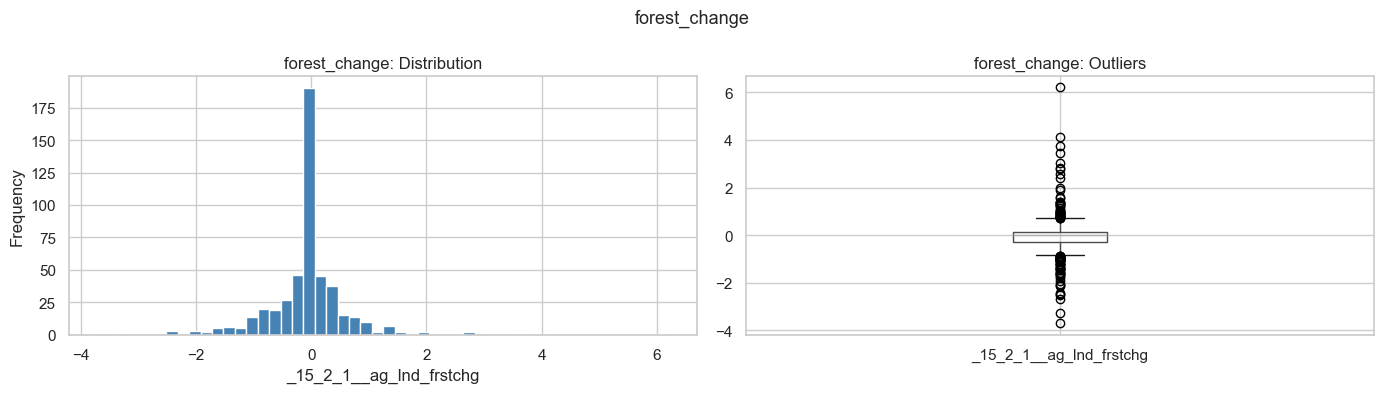

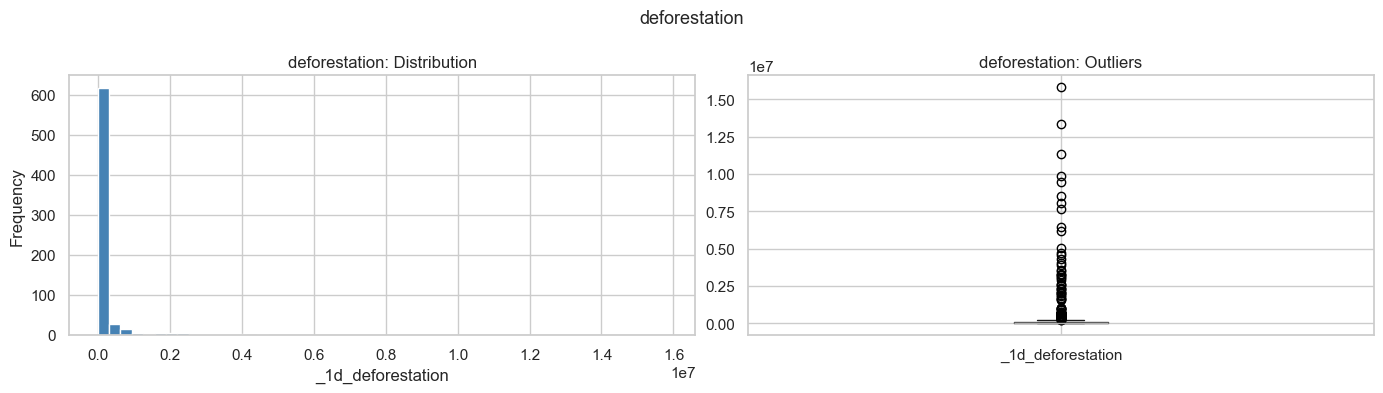

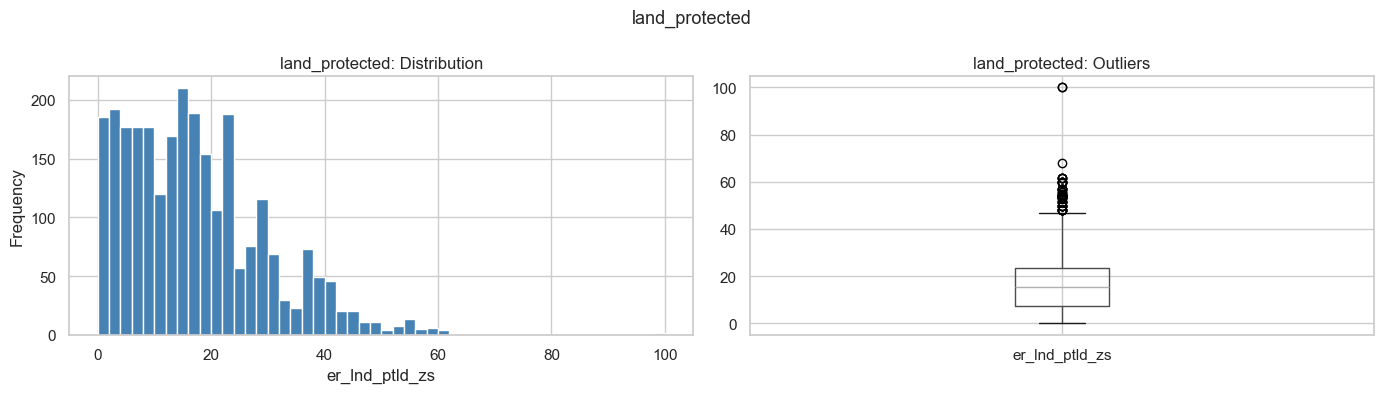

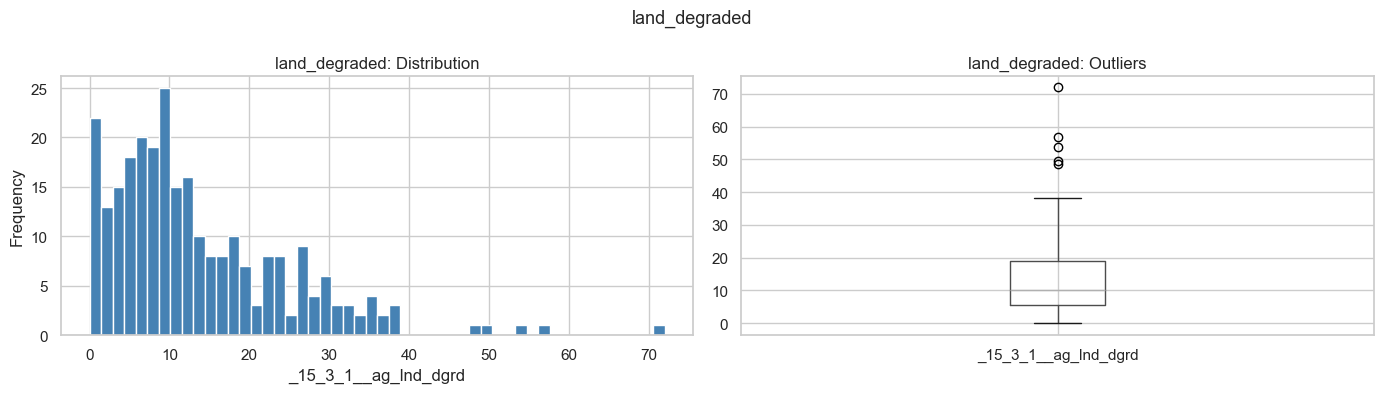

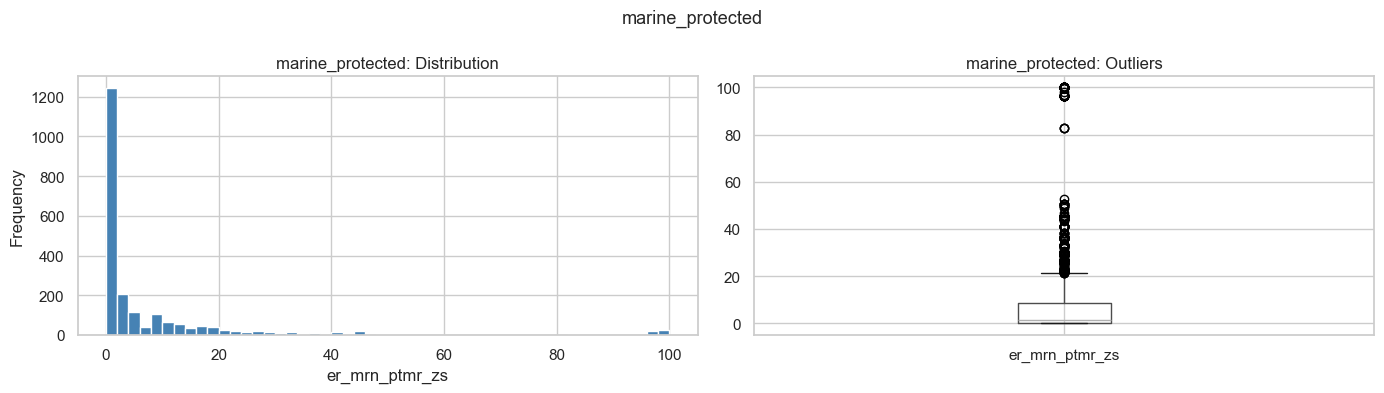

In [12]:
# identifying value columns (everything that's not entity, code, year)

META_COLS = {"entity", "code", "year"}

# checking distribution and box plots side by side for each dataset

for name, df in dfs.items():
    value_cols = [c for c in df.columns if c not in META_COLS]
    
    for col in value_cols:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        
        # Histogram
        df[col].dropna().hist(bins=50, ax=ax1, color="steelblue", edgecolor="white")
        ax1.set_title(f"{name}: Distribution")
        ax1.set_xlabel(col)
        ax1.set_ylabel("Frequency")
        
        # Box plot
        df.boxplot(column=col, ax=ax2)
        ax2.set_title(f"{name}: Outliers")
        
        plt.suptitle(name, fontsize=13)
        plt.tight_layout()
        plt.show()

In [13]:
# identifying top 5 outliers per dataset

for name, df in dfs.items():
    value_col = [c for c in df.columns if c not in META_COLS][0]
    
    print(f"\n--- {name}: top 5 by {value_col} ---")
    top5 = df.nlargest(5, value_col)[["entity", "code", "year", value_col]]
    display(top5)
    
    # For forest_change, also show bottom 5 (biggest losers)
    if name == "forest_change":
        print(f"\n--- {name}: bottom 5 ---")
        bottom5 = df.nsmallest(5, value_col)[["entity", "code", "year", value_col]]
        display(bottom5)


--- forest_change: top 5 by _15_2_1__ag_lnd_frstchg ---


,entity,code,year,_15_2_1__ag_lnd_frstchg
182,Guernsey,GGY,2010,6.21
196,Iceland,ISL,2010,4.12
71,Burundi,BDI,2020,3.73
34,Bahrain,BHR,2010,3.46
35,Bahrain,BHR,2020,3.02



--- forest_change: bottom 5 ---


,entity,code,year,_15_2_1__ag_lnd_frstchg
131,Egypt,EGY,2020,-3.71
103,Cote d'Ivoire,CIV,2020,-3.30
73,Cambodia,KHM,2020,-2.68
306,Nicaragua,NIC,2010,-2.51
102,Cote d'Ivoire,CIV,2010,-2.47



--- deforestation: top 5 by _1d_deforestation ---


,entity,code,year,_1d_deforestation
690,World,OWID_WRL,1990,15818830
691,World,OWID_WRL,2000,13328570
658,Upper-middle-income countries,NaN,1990,11349450
692,World,OWID_WRL,2010,9880680
693,World,OWID_WRL,2015,9473750



--- land_protected: top 5 by er_lnd_ptld_zs ---


,entity,code,year,er_lnd_ptld_zs
1642,Morocco,MAR,2014,100.0
1814,Northern Mariana Islands,MNP,2014,100.0
2144,Seychelles,SYC,2024,68.1
2140,Seychelles,SYC,2020,61.5
2141,Seychelles,SYC,2021,61.5



--- land_degraded: top 5 by _15_3_1__ag_lnd_dgrd ---


,entity,code,year,_15_3_1__ag_lnd_dgrd
152,Mexico,MEX,2019,71.93
151,Mexico,MEX,2015,56.69
99,Haiti,HTI,2015,53.88
194,Philippines,PHL,2019,49.44
61,Dominican Republic,DOM,2015,48.59



--- marine_protected: top 5 by er_mrn_ptmr_zs ---


,entity,code,year,er_mrn_ptmr_zs
1314,Monaco,MCO,2024,100.0
1402,New Caledonia,NCL,2024,100.0
1464,Northern Mariana Islands,MNP,2014,100.0
1517,Palau,PLW,2019,100.0
1518,Palau,PLW,2020,100.0


**Comments:** Some severe outliers are present and identified. However, none of these outliers seem unreasonable. 
1. **Forest change:** Negative values are expected (forest areas per country shrinking)
2. **Deforestation:** Largest outliers for aggregated categories
3. **Land protected:** 100% is reasonable for certain countries
4. **Land degraded:** No severe outliers here, numbers seem reasonable
5. **Marine protected:** 100% is reasonable for certain countries

Thus, no further action required.

# Merge Key Compatibility

Check how the OWID `Code` column aligns with the Natural Earth `ISO_A3` column — this is critical for the GeoPandas merge.

In [14]:
import geopandas as gpd

# Download Natural Earth data
MAP_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
map_path = DOWNLOAD_DIR / "ne_110m_admin_0_countries.zip"

if not map_path.exists():
    print("Downloading Natural Earth map data...")
    urllib.request.urlretrieve(MAP_URL, map_path)

world = gpd.read_file(map_path)
print(f"World map: {world.shape[0]} countries, {world.shape[1]} columns")
print(f"\nKey columns: {[c for c in world.columns if 'ISO' in c or 'NAME' in c]}")
world[["NAME", "ISO_A3", "ISO_A3_EH"]].head(10)

World map: 177 countries, 169 columns

Key columns: ['NAME', 'NAME_LONG', 'BRK_NAME', 'NAME_CIAWF', 'NAME_SORT', 'NAME_ALT', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'ADM0_ISO', 'NAME_LEN', 'NAME_AR', 'NAME_BN', 'NAME_DE', 'NAME_EN', 'NAME_ES', 'NAME_FA', 'NAME_FR', 'NAME_EL', 'NAME_HE', 'NAME_HI', 'NAME_HU', 'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL', 'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_UK', 'NAME_UR', 'NAME_VI', 'NAME_ZH', 'NAME_ZHT', 'FCLASS_ISO']


,NAME,ISO_A3,ISO_A3_EH
0,Fiji,FJI,FJI
1,Tanzania,TZA,TZA
2,W. Sahara,ESH,ESH
3,Canada,CAN,CAN
4,United States of America,USA,USA
5,Kazakhstan,KAZ,KAZ
6,Uzbekistan,UZB,UZB
7,Papua New Guinea,PNG,PNG
8,Indonesia,IDN,IDN
9,Argentina,ARG,ARG


In [15]:
# Check for problematic ISO_A3 values in Natural Earth (some are "-99")
problematic = world[world["ISO_A3"] == "-99"][["NAME", "ISO_A3", "ISO_A3_EH"]]
print(f"Countries with ISO_A3 = '-99': {len(problematic)}")
display(problematic)

print("\n-> Consider using ISO_A3_EH instead of ISO_A3 for merging (it has fewer -99 values)")
problematic_eh = world[world["ISO_A3_EH"] == "-99"][["NAME", "ISO_A3", "ISO_A3_EH"]]
print(f"Countries with ISO_A3_EH = '-99': {len(problematic_eh)}")
display(problematic_eh)

Countries with ISO_A3 = '-99': 5


,NAME,ISO_A3,ISO_A3_EH
21,Norway,-99,NOR
43,France,-99,FRA
160,N. Cyprus,-99,-99
167,Somaliland,-99,-99
174,Kosovo,-99,-99



-> Consider using ISO_A3_EH instead of ISO_A3 for merging (it has fewer -99 values)
Countries with ISO_A3_EH = '-99': 3


,NAME,ISO_A3,ISO_A3_EH
160,N. Cyprus,-99,-99
167,Somaliland,-99,-99
174,Kosovo,-99,-99


In [17]:
# Check merge coverage: how many OWID codes match Natural Earth?
ne_codes = set(world["ISO_A3_EH"].unique())

for name, df in dfs.items():
    owid_codes = set(df["code"].dropna().unique())
    # Remove OWID aggregate codes
    owid_country_codes = {c for c in owid_codes if not c.startswith("OWID_")}
    
    matched = owid_country_codes & ne_codes
    unmatched_owid = owid_country_codes - ne_codes
    unmatched_ne = ne_codes - owid_country_codes
    
    print(f"\n--- {name} ---")
    print(f"  OWID country codes: {len(owid_country_codes)}")
    print(f"  Matched with NE:    {len(matched)}")
    print(f"  In OWID but not NE: {len(unmatched_owid)} -> {sorted(unmatched_owid)[:10]}...")
    print(f"  In NE but not OWID: {len(unmatched_ne)} -> {sorted(unmatched_ne)[:10]}...")


--- forest_change ---
  OWID country codes: 226
  Matched with NE:    168
  In OWID but not NE: 58 -> ['ABW', 'AIA', 'AND', 'ASM', 'ATG', 'BES', 'BHR', 'BMU', 'BRB', 'COK']...
  In NE but not OWID: 7 -> ['-99', 'ALB', 'ATA', 'ATF', 'FLK', 'QAT', 'TWN']...

--- deforestation ---
  OWID country codes: 139
  Matched with NE:    118
  In OWID but not NE: 21 -> ['BHR', 'COM', 'CYM', 'DMA', 'FRO', 'GIB', 'IMN', 'JEY', 'LIE', 'MCO']...
  In NE but not OWID: 57 -> ['-99', 'AFG', 'ALB', 'ARE', 'ARM', 'ATA', 'ATF', 'BDI', 'BHS', 'BIH']...

--- land_protected ---
  OWID country codes: 220
  Matched with NE:    169
  In OWID but not NE: 51 -> ['ABW', 'AND', 'ASM', 'ATG', 'BHR', 'BMU', 'BRB', 'COM', 'CPV', 'CUW']...
  In NE but not OWID: 6 -> ['-99', 'ATA', 'ATF', 'ESH', 'FLK', 'TWN']...

--- land_degraded ---
  OWID country codes: 121
  Matched with NE:    114
  In OWID but not NE: 7 -> ['ATG', 'DMA', 'LCA', 'MUS', 'PLW', 'STP', 'VCT']...
  In NE but not OWID: 61 -> ['-99', 'AFG', 'AGO', 'ALB', '

**Findings:**

- OWID uses the `code` column as the main identifier
  - Real countries use ISO alpha-3 codes (e.g., `DEU`, `FRA`, `USA`)
  - Aggregate regions use missing values or special codes (e.g., `OWID_WRL`)

- Natural Earth also provides ISO alpha-3 codes, with `ISO_A3_EH` being the most reliable column for merging

- There is strong overlap between OWID and Natural Earth ISO codes, confirming that ISO alpha-3 codes are the best merge key

**Conclusion:**

The `code` column will be used as the primary merge key. Aggregate regions will be retained but flagged separately, and only valid ISO alpha-3 codes will be used for geographic merges.

# 8. EDA Summary

- All OWID datasets share the same *long* schema: `entity`, `code`, `year`, `value`
- Duplicate checks show no duplicates, but we will still remove duplicates defensively in preprocessing
- Rows with missing `code` and rows with `code` like `OWID_*` represent aggregate regions (e.g., World/continents/income groups). We keep them for later visualizations
- For map merging later, ISO alpha-3 codes are the most reliable key:
  - we will treat a row as mappable only if `code` is strictly a valid ISO A3 pattern (`len==3` and alphabetic).
- No meaningful missing values in `value` were found, and extreme values appear plausible → no outlier removal
- Preprocessing should standardize types (`year` → int, `value` → float), add flags for filtering, and return cleaned copies (do not mutate raw inputs)

# 9. Preprocessing Function (Prototype)

In [25]:
# imports should be at the top, but placing here for context with the new function
from __future__ import annotations
from typing import Dict
import pandas as pd


def preprocess_owid_datasets(datasets: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Clean OWID-style datasets (long format) prior to merging with a GeoDataFrame.

    Expected base columns per dataset: ['entity', 'code', 'year'] + ONE metric/value column
    (the metric column name differs per dataset).

    Adds:
      - is_aggregate: bool  (code is NA or starts with 'OWID_')
      - is_mappable: bool   (strict ISO A3: exactly 3 alphabetic characters AND not aggregate)

    Returns NEW DataFrames (does not mutate inputs).
    """
    required_base = {"entity", "code", "year"}
    cleaned: Dict[str, pd.DataFrame] = {}

    for name, df in datasets.items():
        # --- validate base schema ---
        missing = required_base - set(df.columns)
        if missing:
            raise ValueError(f"Dataset '{name}' is missing required columns: {sorted(missing)}")

        out = df.copy(deep=True)

        # --- detect metric column (dataset-specific) ---
        # Prefer META_COLS if you have it in the notebook; otherwise infer.
        meta_cols = {"entity", "code", "year"}  # keep local default
        metric_candidates = [c for c in out.columns if c not in meta_cols]

        if len(metric_candidates) != 1:
            raise ValueError(
                f"Dataset '{name}' has ambiguous metric columns. "
                f"Expected exactly 1 non-meta column, found: {metric_candidates}"
            )

        metric_col = metric_candidates[0]

        # --- enforce dtypes ---
        out["year"] = pd.to_numeric(out["year"], errors="coerce").astype("Int64")
        out[metric_col] = pd.to_numeric(out[metric_col], errors="coerce")

        # --- flags ---
        code = out["code"]
        code_str = code.astype("string")

        out["is_aggregate"] = code.isna() | code_str.str.startswith("OWID_", na=False)

        iso_like = code_str.str.fullmatch(r"[A-Za-z]{3}", na=False)
        out["is_mappable"] = (~out["is_aggregate"]) & iso_like

        # --- defensive dedupe (key) ---
        out = out.drop_duplicates(subset=["entity", "code", "year"], keep="first")

        # --- sort for stability ---
        out = out.sort_values(
            by=["is_aggregate", "code", "entity", "year"],
            na_position="last",
        ).reset_index(drop=True)

        cleaned[name] = out

    return cleaned

# 10. Function test

In [32]:
# Apply preprocessing to your local datasets
cleaned = preprocess_owid_datasets(dfs)

# View the cleaned version of one dataset
cleaned["forest_change"].head()

,entity,code,year,_15_2_1__ag_lnd_frstchg,is_aggregate,is_mappable
0,Aruba,ABW,2010,0.00,False,True
1,Aruba,ABW,2020,0.00,False,True
2,Afghanistan,AFG,2010,0.00,False,True
3,Afghanistan,AFG,2020,0.00,False,True
4,Angola,AGO,2010,-0.74,False,True
